In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import os, requests
from matplotlib import pyplot as plt

import matplotlib.cm as cm
colormap = cm.viridis

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Import plot functions and define parameters

In [3]:
# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Load data

In [4]:
# Load Data
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:        
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)

In [5]:
# Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# hide_toggle()

In [6]:
alldat.shape[0]

39

## Select session and group brain regions

In [7]:
def load_data(n_session):
    dat = alldat[n_session]

    # groupings of brain regions
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                    ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                    ]

    nareas = 4 # only the top 4 regions are in this particular mouse
    NN = len(dat['brain_area']) # number of neurons
    barea = nareas * np.ones(NN, ) # last one is "other"
    for j in range(nareas):
        barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region
        
    return dat, barea, NN, regions, brain_groups, nareas

# dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)

## Define functions: contrast difference

In [8]:
# n_session = 1

def get_task_difference(n_session):
    dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    l_cont = dat['contrast_left']
    r_cont = dat['contrast_right']
    
    task_diff = np.abs(l_cont - r_cont)
    dtask_diff = np.diff(task_diff)
#     print(np.unique(dtask_diff))
    dtdiff = np.insert(dtask_diff, 0, 0)
#     print(dtdiff.shape)

    return dt, NT, task_diff, dtask_diff, dtdiff

# dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(1)

In [9]:
def get_total_contrast(n_session):
    dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)
    
    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    l_cont = dat['contrast_left']
    r_cont = dat['contrast_right']
    
    t_cont = np.abs(l_cont + r_cont)
    dt_cont = np.diff(t_cont)
    dtcont = np.insert(dt_cont, 0, 0)

    return dt, NT, t_cont, dt_cont, dtcont
# dt, NT, t_cont, dt_cont, dtcont = get_total_contrast(11)

In [10]:
def plot_trial_history(task_diff, dtask_diff, n_session, dat):
    """
    Make a plot of the trial by trial contrast difference and change in contrast difference.
    """
    fig = plt.figure(figsize=(12,4))
    plt.plot(task_diff,'.r', label='contrast difference')
    plt.plot(dtask_diff,'--', label='change in contrast difference')
    plt.xlabel('Trial')
    plt.ylabel('Contrast difference')
    plt.title('Session: %1.0f, '%n_session + dat['mouse_name'])
    plt.legend()
    plt.show()

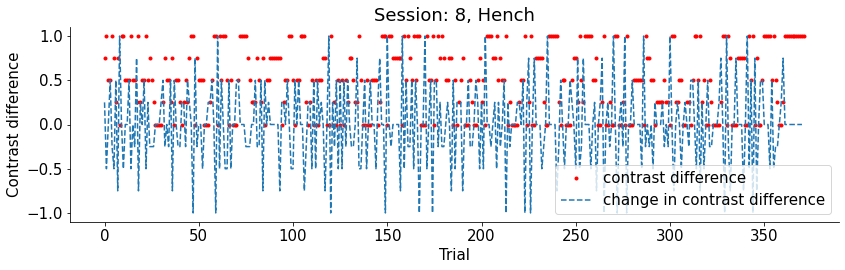

In [11]:
n_session = 8
dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)
dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(n_session)
plot_trial_history(task_diff, dtask_diff, n_session, dat)

## Mean firing rate for change in contrast difference $\Delta$

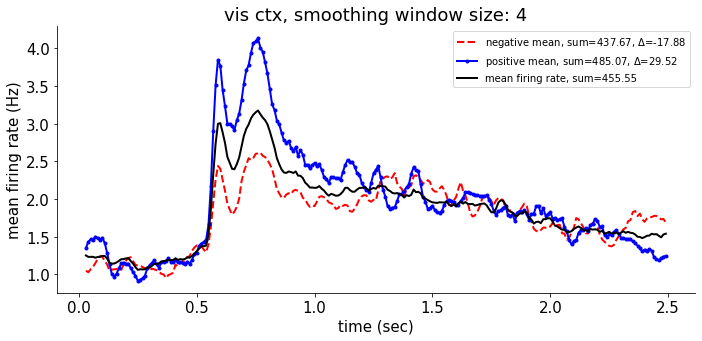

In [12]:
def plot_firing_rate_vs_dcontrast_change(dat, dtdiff, j_barea):
    
    assert dat['spks'][:, dtdiff==-1][barea==j_barea].shape[0] != 0, 'No recording from this cortex.'

    win_size = 4
    fig = plt.figure(figsize=(10,5))
    neg_spk = np.zeros(dat['spks'].shape[2])
    pos_spk = np.zeros(dat['spks'].shape[2])

    for i, value in enumerate(np.unique(dtdiff)):
        if value<0:
            neg_spk += dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))
#             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=4).mean(),
#                      label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
        elif value>0:
            pos_spk += dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))
#             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=4).mean(),
#                      label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
        else:
#             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=4).mean(),
#                      '--', label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
            value = 0
    
    neg_sum = pd.Series(1/dt*neg_spk/4).rolling(window=win_size).mean().sum()
    pos_sum = pd.Series(1/dt*pos_spk/4).rolling(window=win_size).mean().sum()
    mean_sum = pd.Series(1/dt*dat['spks'][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean().sum()

    plt.plot(dt * np.arange(NT), 1/dt * pd.Series(neg_spk/4).rolling(window=win_size).mean(), 'r--',
             label='negative mean, sum=%1.2f'%neg_sum+', $\Delta$=%1.2f'%(neg_sum-mean_sum), linewidth=2)
    plt.plot(dt * np.arange(NT), 1/dt * pd.Series(pos_spk/4).rolling(window=win_size).mean(), 'b.-',
             label='positive mean, sum=%1.2f'%pos_sum+', $\Delta$=%1.2f'%(pos_sum-mean_sum), linewidth=2)

    plt.plot(dt*np.arange(NT), 1/dt*pd.Series(dat['spks'][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(), 
             'k-', 
             label='mean firing rate, sum=%1.2f'%mean_sum, linewidth=2)
    
    plt.xlabel('time (sec)')
    plt.ylabel('mean firing rate (Hz)')
    plt.title(regions[j_barea]+', smoothing window size: %1.0f'%win_size)
    plt.legend(fontsize=10)
    plt.show()
    
plot_firing_rate_vs_dcontrast_change(dat, dtdiff, 0)
hide_toggle()

In [13]:
dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(11)

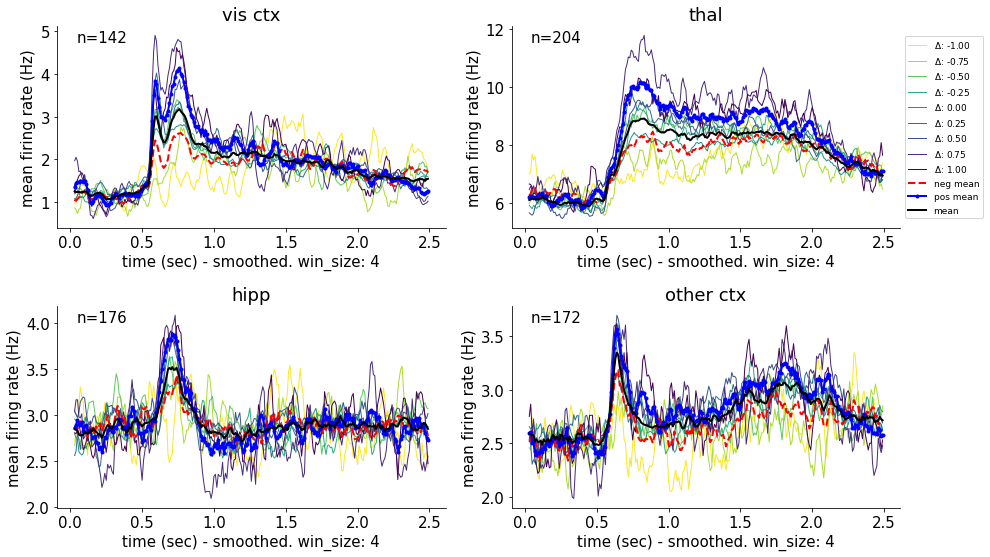

In [60]:
def plot_firing_ctx_means(dat, nareas, dtdiff):

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    win_size = 4
    colors = plt.cm.viridis(np.linspace(0,1,len(np.unique(dtask_diff))))
    
    fig = plt.subplots(2, nareas//2, figsize=(14,8))

    for j_barea in range(nareas):
        neg_spk = np.zeros(dat['spks'].shape[2])
        pos_spk = np.zeros(dat['spks'].shape[2])

        ax = plt.subplot(2,nareas//2,j_barea+1)

        for i, value in enumerate(np.unique(dtask_diff)):
            plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(),
                     label=r'$\Delta$: %1.2f'%value, color=colors[len(np.unique(dtask_diff))-i-1], linewidth=1)
            if value<0:
                neg_spk += dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))
    #             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(),
    #                      label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
            elif value>0:
                pos_spk += dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))
    #             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(),
    #                      label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
            else:
    #             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(),
    #                      '--', label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
                value = 0

        neg_sum = pd.Series(1/dt*neg_spk/4).rolling(window=win_size).mean().sum()
        pos_sum = pd.Series(1/dt*pos_spk/4).rolling(window=win_size).mean().sum()
        mean_sum = pd.Series(1/dt*dat['spks'][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean().sum()

        plt.plot(dt * np.arange(NT), 1/dt * pd.Series(neg_spk/4).rolling(window=win_size).mean(), 'r--',
                 label='neg mean', linewidth=2)
        plt.plot(dt * np.arange(NT), 1/dt * pd.Series(pos_spk/4).rolling(window=win_size).mean(), 'b.-',
                 label='pos mean', linewidth=2)

        plt.plot(dt*np.arange(NT), 1/dt*pd.Series(dat['spks'][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(), 'k-', 
                label='mean', linewidth=2)

        plt.text(.05, .92, 'n=%d'%np.sum(barea==j_barea), transform=ax.transAxes)

        if j_barea==1:
            plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=9)

        ax.set(xlabel = 'time (sec) - smoothed. win_size: %1.0f'%win_size, 
               ylabel = r'mean firing rate (Hz)')
        ax.set_title(regions[j_barea])
#                      +r': $\Sigma\bar{f}$=%1.2f'%mean_sum 
#                      +', $\Sigma$-=%1.2f'%neg_sum + '(%1.2f)'%(neg_sum-mean_sum)
#                      +', $\Sigma$+=%1.2f'%pos_sum + '(%1.2f)'%(pos_sum-mean_sum), 
#                      fontsize=12)

    plt.show()

plot_firing_ctx_means(dat, nareas, dtdiff)

hide_toggle()

In [17]:
def plot_firing_ctx(dat, nareas):

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    colors = plt.cm.viridis(np.linspace(0,1,len(np.unique(dtask_diff))))
    win_size = 6

    fig = plt.subplots(2, nareas//2, figsize=(14,8))

    for j in range(nareas):
        ax = plt.subplot(2,nareas//2,j+1)

        for i, value in enumerate(np.unique(dtask_diff)):
            plt.plot(dt * np.arange(NT), 
                     1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j].mean(axis=(0,1))).rolling(window=win_size).mean(),
                     label=r'$\Delta$: %1.2f'%value, 
                     color=colors[len(np.unique(dtask_diff))-i-1])

        plt.text(.05, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

        if j==1:
            plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=9)

        ax.set(xlabel = 'time (sec) - smoothed. win_size: %1.0f'%win_size, ylabel = r'mean firing rate (Hz)', title = regions[j])

# plot_firing_ctx(dat, nareas)
hide_toggle()

8


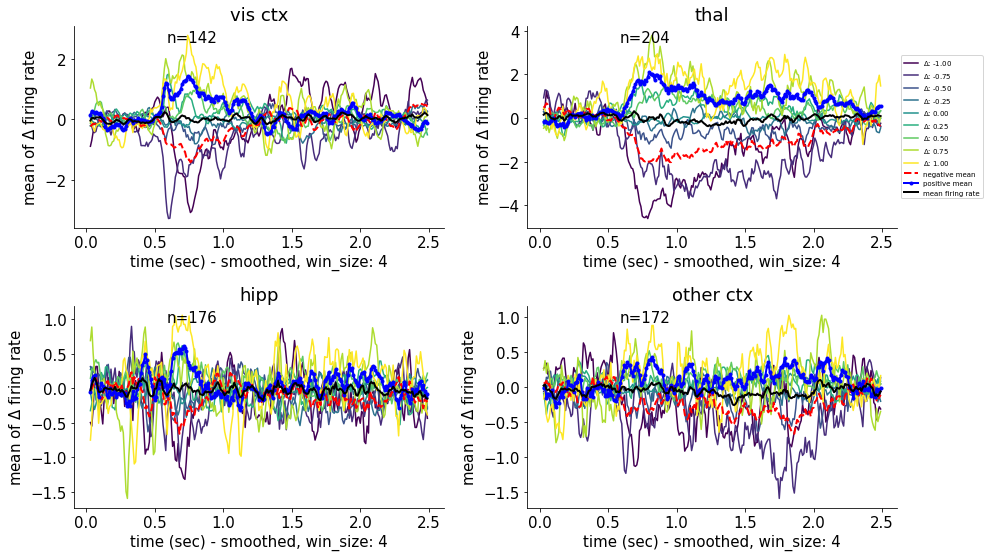

In [30]:
def plot_mean_f_change(dat, nareas, dtask_diff):

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]
    dspks = np.diff(dat['spks'],axis=1)

    win_size = 4

    fig = plt.subplots(2, nareas//2, figsize=(14,8))

    for j in range(nareas):
        ax = plt.subplot(2,nareas//2,j+1)

        neg_spk = np.zeros(dat['spks'].shape[2])
        pos_spk = np.zeros(dat['spks'].shape[2])
        n_neg = 0
        n_pos = 0
        for i, value in enumerate(np.unique(dtask_diff)):
            colors = plt.cm.viridis(np.linspace(0,1,len(np.unique(dtask_diff))))

    #         plt.plot(dt*np.arange(NT), 1/dt*dspks[:,dtask_diff==value][barea==j].mean(axis=(0,1)), label=r'$\Delta$: %1.2f'%value)
            plt.plot(dt*np.arange(NT), 1/dt*pd.Series(dspks[:,dtask_diff==value][barea==j].mean(axis=(0,1))).rolling(window=win_size).mean(), 
                     color = colors[i], label=r'$\Delta$: %1.2f'%value)
            if value<0:
                neg_spk += dspks[:,dtask_diff==value][barea==j].mean(axis=(0,1))
                n_neg += 1
            elif value>0:
                pos_spk += dspks[:,dtask_diff==value][barea==j].mean(axis=(0,1))
                n_pos += 1 
            else:
                value = 0

        neg_sum = pd.Series(1/dt*neg_spk/n_neg).rolling(window=win_size).mean().sum()
        pos_sum = pd.Series(1/dt*pos_spk/n_pos).rolling(window=win_size).mean().sum()
        mean_sum = pd.Series(1/dt*dat['spks'][barea==j].mean(axis=(0,1))).rolling(window=win_size).mean().sum()

        plt.plot(dt * np.arange(NT), 1/dt * pd.Series(neg_spk/n_neg).rolling(window=win_size).mean(), 'r--',
                 label='negative mean', linewidth=2)
        plt.plot(dt * np.arange(NT), 1/dt * pd.Series(pos_spk/n_pos).rolling(window=win_size).mean(), 'b.-',
                 label='positive mean', linewidth=2)

        plt.plot(dt*np.arange(NT), 1/dt*pd.Series((neg_spk + pos_spk)/(n_neg+n_pos)).rolling(window=win_size).mean(), 
                 'k-', 
                 label='mean firing rate', linewidth=2)


        # Timing indicator
    #     plt.axvline(x=0.5,color='b')                         # stimulus onset
    #     plt.axvline(x=dat['gocue'].mean(),color='r')         # go cue
    #     plt.axvline(x=dat['response_time'].mean(),color='y') # response time
    #     plt.axvline(x=dat['feedback_time'].mean(),color='g') # feedback time

        plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

        if j==1:
            plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=7)

        ax.set(xlabel = 'time (sec) - smoothed, win_size: %1.0f'%win_size, 
               ylabel = r'mean of $\Delta$ firing rate', 
               title = regions[j])

print(n_session)
plot_mean_f_change(dat, nareas, dtask_diff)

hide_toggle()

## Mean firing rate for change in total contrast ($\Sigma$)

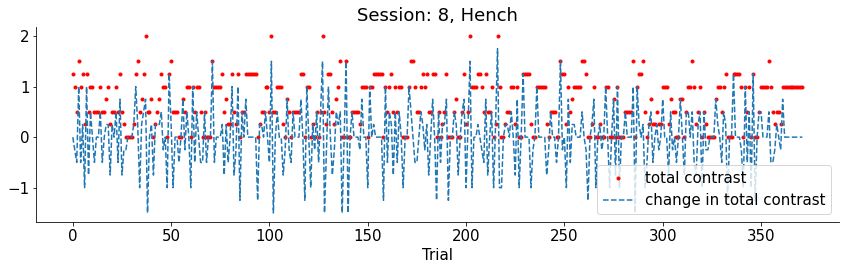

In [19]:
def plot_tcont_history(d_cont, ddcont, n_session, dat):
    """
    Make a plot of the trial by trial total contrast and change in total contrast.
    """
    fig = plt.figure(figsize=(12,4))
    plt.plot(d_cont,'.r', label='total contrast')
    plt.plot(ddcont,'--', label='change in total contrast')
    plt.xlabel('Trial')
#     plt.ylabel('total contrast')
    plt.title('Session: %1.0f, '%n_session + dat['mouse_name'])
    plt.legend(loc=4)
    plt.show()

n_session = 8
dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)
dt, NT, t_cont, dt_cont, dtcont = get_total_contrast(n_session)
plot_tcont_history(t_cont, dtcont, n_session, dat)

hide_toggle()

In [20]:
dat, barea, NN, regions, brain_groups, nareas = load_data(11)

In [21]:
dt, NT, t_cont, dt_cont, dtcont = get_total_contrast(11)
# regions, dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(11)
# np.unique(dt_cont)
dtcont.shape

(340,)

In [22]:
dat['spks'].shape

(698, 340, 250)

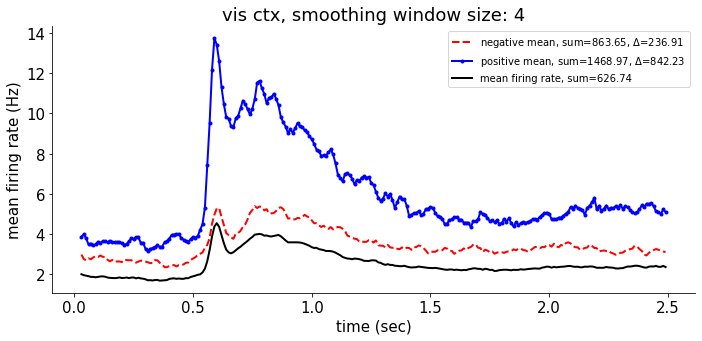

In [23]:
def plot_firing_rate_vs_tot_contrast_change(dat, dtcont, j_barea):
    
#     assert dat['spks'][:, dtcont==-1][barea==j_barea].shape[0] != 0, 'No recording from this cortex.'

    win_size = 4
    fig = plt.figure(figsize=(10,5))
    neg_spk = np.zeros(dat['spks'].shape[2])
    pos_spk = np.zeros(dat['spks'].shape[2])

    for i, value in enumerate(np.unique(dtcont)):
        if value<0:
            neg_spk += dat['spks'][:,dtcont==value][barea==j_barea].mean(axis=(0,1))
#             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=4).mean(),
#                      label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
        elif value>0:
            pos_spk += dat['spks'][:,dtcont==value][barea==j_barea].mean(axis=(0,1))
#             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=4).mean(),
#                      label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
        else:
#             plt.plot(dt * np.arange(NT), 1/dt * pd.Series(dat['spks'][:,dtdiff==value][barea==j_barea].mean(axis=(0,1))).rolling(window=4).mean(),
#                      '--', label=r'$\Delta$: %1.2f'%value, linewidth=3, color=colors[i]) # barea = 0 for visual
            value = 0
    
    neg_sum = pd.Series(1/dt*neg_spk/4).rolling(window=win_size).mean().sum()
    pos_sum = pd.Series(1/dt*pos_spk/4).rolling(window=win_size).mean().sum()
    mean_sum = pd.Series(1/dt*dat['spks'][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean().sum()

    plt.plot(dt * np.arange(NT), 1/dt * pd.Series(neg_spk/4).rolling(window=win_size).mean(), 'r--',
             label='negative mean, sum=%1.2f'%neg_sum+', $\Delta$=%1.2f'%(neg_sum-mean_sum), linewidth=2)
    plt.plot(dt * np.arange(NT), 1/dt * pd.Series(pos_spk/4).rolling(window=win_size).mean(), 'b.-',
             label='positive mean, sum=%1.2f'%pos_sum+', $\Delta$=%1.2f'%(pos_sum-mean_sum), linewidth=2)

    plt.plot(dt*np.arange(NT), 1/dt*pd.Series(dat['spks'][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(), 
             'k-', 
             label='mean firing rate, sum=%1.2f'%mean_sum, linewidth=2)
    
    plt.xlabel('time (sec)')
    plt.ylabel('mean firing rate (Hz)')
    plt.title(regions[j_barea]+', smoothing window size: %1.0f'%win_size)
    plt.legend(fontsize=10)
    plt.show()
    
plot_firing_rate_vs_tot_contrast_change(dat, dtcont, 0)
hide_toggle()

In [24]:
dat['spks'].shape

(698, 340, 250)

In [31]:
def plot_firing_ctx_tot(dat, nareas, dtcont):

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]
    colors = plt.cm.viridis(np.linspace(0,1,len(np.unique(dtcont))))

    win_size = 6

    fig = plt.subplots(2, nareas//2, figsize=(14,8))

    for j in range(nareas):
        ax = plt.subplot(2,nareas//2,j+1)

        for i, value in enumerate(np.unique(dtcont)):
            plt.plot(dt * np.arange(NT), 
                     1/dt * pd.Series(dat['spks'][:,dtcont==value][barea==j].mean(axis=(0,1))).rolling(window=win_size).mean(),
                     label=r'$\Sigma$: %1.2f'%value, 
                     color=colors[len(np.unique(dtcont))-i-1])

        plt.text(.05, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

        if j==1:
            plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=9)

        ax.set(xlabel = 'time (sec) - smoothed. win_size: %1.0f'%win_size, ylabel = r'mean firing rate (Hz)', title = regions[j])

# plot_firing_ctx_tot(dat, nareas, dtcont)
hide_toggle()

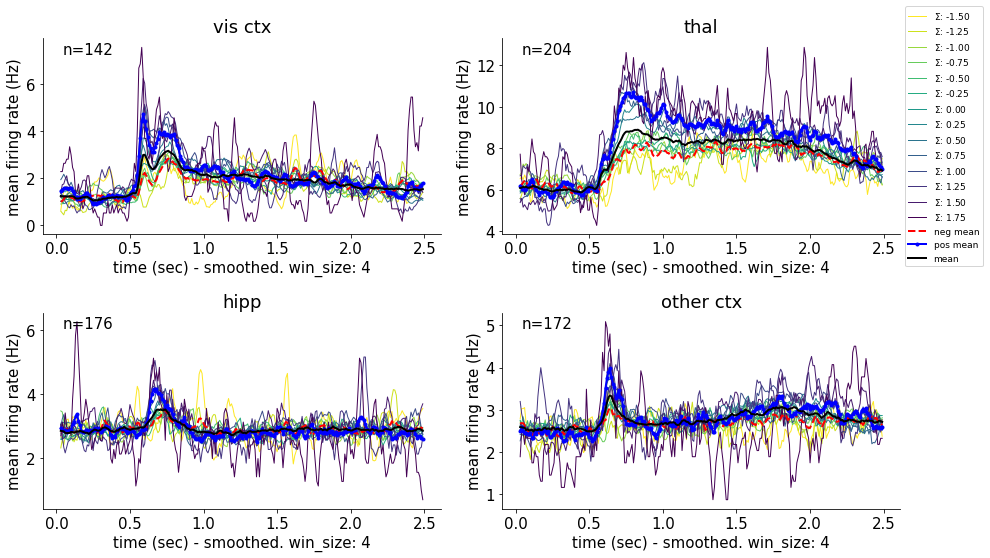

In [69]:
def plot_firing_tot_means(dat, nareas, dtcont):

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    win_size = 4
    colors = plt.cm.viridis(np.linspace(0,1,len(np.unique(dtcont))))
    
    fig = plt.subplots(2, nareas//2, figsize=(14,8))

    for j_barea in range(nareas):
        neg_spk = np.zeros(dat['spks'].shape[2])
        pos_spk = np.zeros(dat['spks'].shape[2])
        n_neg = 0
        n_pos = 0
        
        ax = plt.subplot(2,nareas//2,j_barea+1)

        for i, value in enumerate(np.unique(dtcont)):
            plt.plot(dt * np.arange(NT), 
                     1/dt * pd.Series(dat['spks'][:,dtcont==value][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(),
                     label=r'$\Sigma$: %1.2f'%value, 
                     color=colors[len(np.unique(dtcont))-i-1], 
                     linewidth=1)
            if value<0:
                neg_spk += dat['spks'][:,dtcont==value][barea==j_barea].mean(axis=(0,1))
                n_neg += 1
            elif value>0:
                pos_spk += dat['spks'][:,dtcont==value][barea==j_barea].mean(axis=(0,1))
                n_pos += 1
            else:
                value = 0

        neg_sum = pd.Series(1/dt*neg_spk/4).rolling(window=win_size).mean().sum()
        pos_sum = pd.Series(1/dt*pos_spk/4).rolling(window=win_size).mean().sum()
        mean_sum = pd.Series(1/dt*dat['spks'][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean().sum()

        plt.plot(dt * np.arange(NT), 1/dt * pd.Series(neg_spk/n_neg).rolling(window=win_size).mean(), 'r--',
                 label='neg mean', linewidth=2)
        plt.plot(dt * np.arange(NT), 1/dt * pd.Series(pos_spk/n_pos).rolling(window=win_size).mean(), 'b.-',
                 label='pos mean', linewidth=2)

        plt.plot(dt*np.arange(NT), 1/dt*pd.Series(dat['spks'][barea==j_barea].mean(axis=(0,1))).rolling(window=win_size).mean(), 'k-', 
                label='mean', linewidth=2)

        plt.text(.05, .92, 'n=%d'%np.sum(barea==j_barea), transform=ax.transAxes)

        if j_barea==1:
            plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=9)

        ax.set(xlabel = 'time (sec) - smoothed. win_size: %1.0f'%win_size, 
               ylabel = r'mean firing rate (Hz)')
        ax.set_title(regions[j_barea])
#                      +r': $\Sigma\bar{f}$=%1.2f'%mean_sum 
#                      +', $\Sigma$-=%1.2f'%neg_sum + '(%1.2f)'%(neg_sum-mean_sum)
#                      +', $\Sigma$+=%1.2f'%pos_sum + '(%1.2f)'%(pos_sum-mean_sum), 
#                      fontsize=12)
    plt.show()

plot_firing_tot_means(dat, nareas, dtcont)

hide_toggle()

8
skip plotting


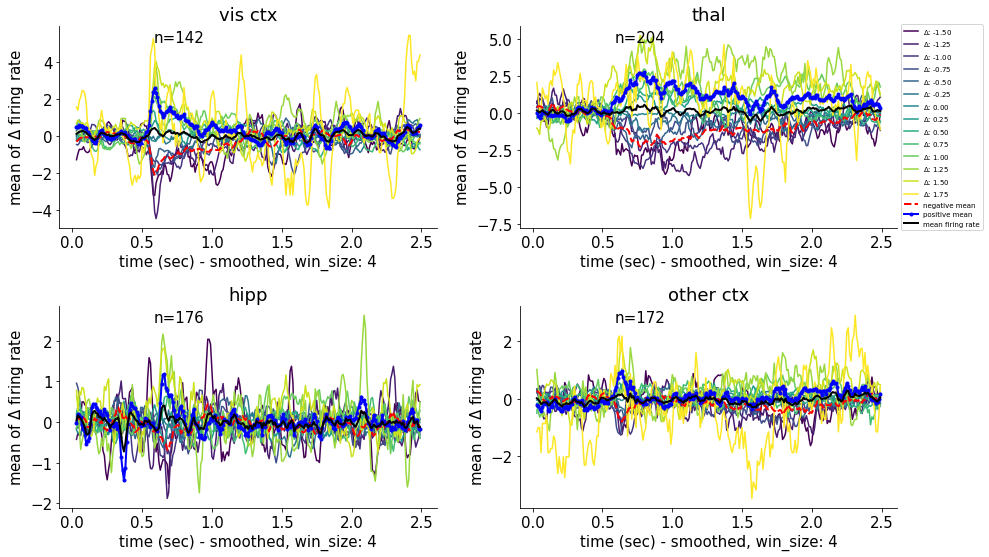

In [56]:
def plot_mean_f_change(dat, nareas, dtask_diff):

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]
    dspks = np.diff(dat['spks'],axis=1)

    win_size = 4

    fig = plt.subplots(2, nareas//2, figsize=(14,8))

    for j in range(nareas):
        ax = plt.subplot(2,nareas//2,j+1)

        neg_spk = np.zeros(dat['spks'].shape[2])
        pos_spk = np.zeros(dat['spks'].shape[2])
        n_neg = 0
        n_pos = 0
        for i, value in enumerate(np.unique(dtask_diff)):
            colors = plt.cm.viridis(np.linspace(0,1,len(np.unique(dtask_diff))))

            if np.max(np.abs(pd.Series(dspks[:,dtask_diff==value][barea==j].mean(axis=(0,1))).rolling(window=win_size).mean())/dt)>9:
                print('skip plotting')
            else:
                plt.plot(dt*np.arange(NT), 
                         1/dt*pd.Series(dspks[:,dtask_diff==value][barea==j].mean(axis=(0,1))).rolling(window=win_size).mean(), 
                         color = colors[i], label=r'$\Delta$: %1.2f'%value)
            if value<0:
                neg_spk += dspks[:,dtask_diff==value][barea==j].mean(axis=(0,1))
                n_neg += 1
            elif value>0:
                pos_spk += dspks[:,dtask_diff==value][barea==j].mean(axis=(0,1))
                n_pos += 1 
            else:
                value = 0

        neg_sum = pd.Series(1/dt*neg_spk/n_neg).rolling(window=win_size).mean().sum()
        pos_sum = pd.Series(1/dt*pos_spk/n_pos).rolling(window=win_size).mean().sum()
        mean_sum = pd.Series(1/dt*dat['spks'][barea==j].mean(axis=(0,1))).rolling(window=win_size).mean().sum()

        plt.plot(dt * np.arange(NT), 1/dt * pd.Series(neg_spk/n_neg).rolling(window=win_size).mean(), 'r--',
                 label='negative mean', linewidth=2)
        plt.plot(dt * np.arange(NT), 1/dt * pd.Series(pos_spk/n_pos).rolling(window=win_size).mean(), 'b.-',
                 label='positive mean', linewidth=2)

        plt.plot(dt*np.arange(NT), 1/dt*pd.Series((neg_spk + pos_spk)/(n_neg+n_pos)).rolling(window=win_size).mean(), 
                 'k-', 
                 label='mean firing rate', linewidth=2)

        plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

        if j==1:
            plt.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=7)

        ax.set(xlabel = 'time (sec) - smoothed, win_size: %1.0f'%win_size, 
               ylabel = r'mean of $\Delta$ firing rate', 
               title = regions[j])

print(n_session)
plot_mean_f_change(dat, nareas, dt_cont)

hide_toggle()

## Check all sessions

n_session:  8


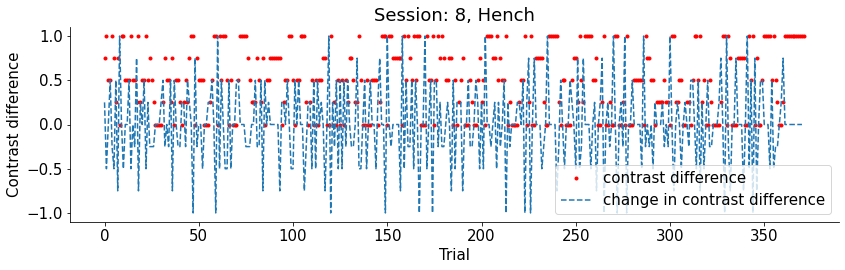

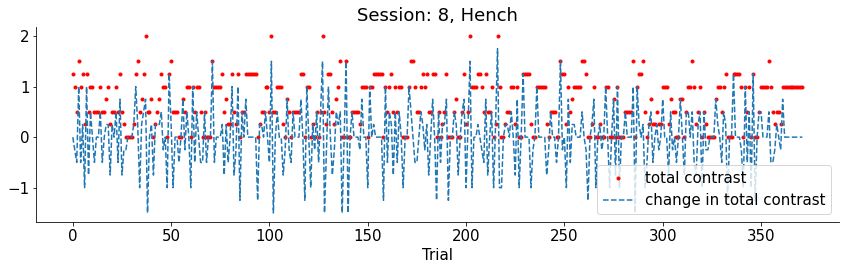

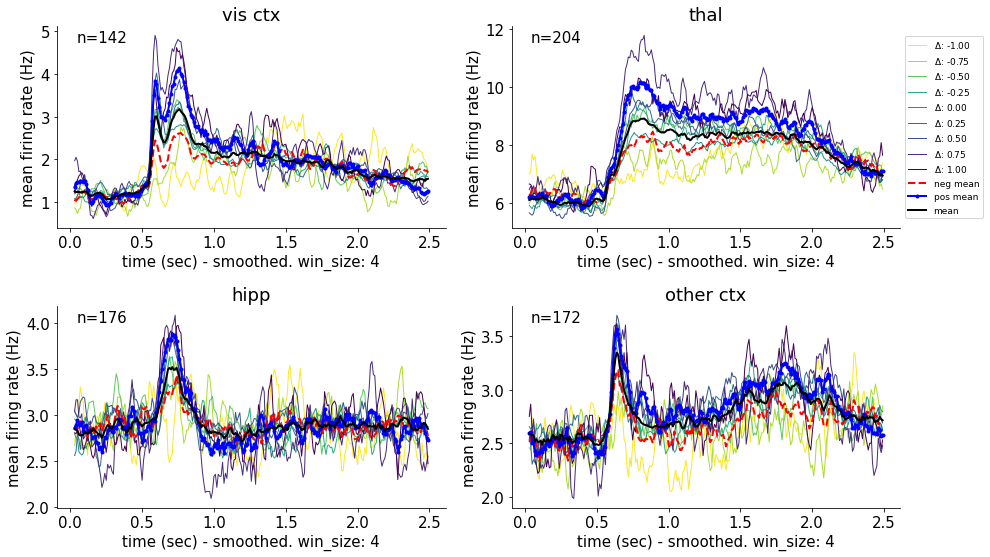

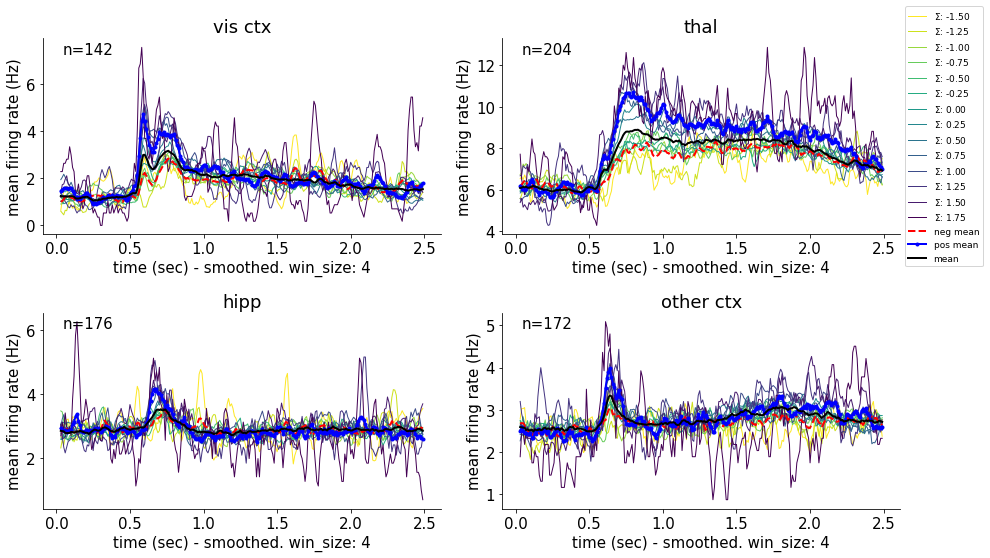

In [61]:
# for n_session in range(alldat.shape[0]):
# for n_session in np.array([3, 7, 8, 11, 12, 26, 27, 29, 34, 38]):
for n_session in np.array([8]):
    print('n_session: ', n_session)
    dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)
    dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(n_session)
    _, _, t_cont, dt_cont, dtcont = get_total_contrast(n_session)
#     print(dat['spks'].shape)
#     print(dtcont.shape)
#     print(dat['mouse_name'])
#     print('nareas: ', nareas)
#     print('------------------------')
    
    # Plot Stuff
    plot_trial_history(task_diff, dtask_diff, n_session, dat)
    plot_tcont_history(t_cont, dtcont, n_session, dat)

    plot_firing_ctx_means(dat, nareas, dtdiff)
    plot_firing_tot_means(dat, nareas, dtcont)
